<a href="https://colab.research.google.com/github/GokulGS/CloudComputing/blob/main/220579243_Gokul_Gopakumar_Sreekala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance evaluation of Terapixel rendering in Cloud (Super)computing


In [2]:
!pip install pandasql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pandas import Series
from datetime import datetime
from google.colab import drive
from pandasql import sqldf
from pandas.core.reshape.api import pivot_table
drive.mount('/content/gdrive')
pysqldf = lambda q: sqldf(q, globals())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Methodology

## Business Understanding

1.	Which event takes more runtime? 
2.	Which task/position takes more runtime?
3.	Which hostnames consume more power draw?
4.	What is average GPU temperature of each GPU serial card and how is GPU temperature is distributed?
5.	What is the relationship between GPU utilisation percentage GPU memory utilisation percentage?
6.	What is the average percentage of power draw consumption for each event name?
7.	What is the correlation between the GPU specifications?


## Data Understanding

In [3]:
#Getting the dataset from the Google drive, Replace with exacet file path.
data1=pd.read_csv('/content/gdrive/MyDrive/Cloud_computing/application-checkpoints.csv')
data2=pd.read_csv('/content/gdrive/MyDrive/Cloud_computing/task-x-y.csv')
data3=pd.read_csv('/content/gdrive/MyDrive/Cloud_computing/gpu.csv')

## Data Preparation

In [4]:
#Remove the duplicates from all the three data files 
cdata1=data1.drop_duplicates()
cdata2=data2.drop_duplicates()
cdata3=data3.drop_duplicates()

In [5]:
#Converting the datatype from integer to string
cdata3["gpuSerial"]=cdata3["gpuSerial"].astype('string')
#Converting the datatype from timestamp to datetime
cdata3["timestamp"]=cdata3["timestamp"].astype('datetime64')


<ipython-input-5-8f1b86dac52f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdata3["gpuSerial"]=cdata3["gpuSerial"].astype('string')
<ipython-input-5-8f1b86dac52f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdata3["timestamp"]=cdata3["timestamp"].astype('datetime64')


## Modeling

1.	Runtime taken for each event

In [6]:
# Query for making the start and stop event type in a single row for calculating the delta time
q7 ="""select q11.timestamp as start_dttm,q12.timestamp as end_dttm,q11.taskId taskId,q11.jobId jobId, q11.hostname, q11.eventName from (select * from cdata1 where  eventType='START') q11 inner join 
(select * from cdata1 where  eventType='STOP') q12 on q11.jobId=q12.jobId and q11.taskId=q12.taskId and q11.eventName=q12.eventName ;"""

q_1_4=pysqldf(q7)
#Converting the timestamp datatype to Datetime
q_1_4["start_dttm"]=q_1_4["start_dttm"].astype('datetime64')
q_1_4["end_dttm"]=q_1_4["end_dttm"].astype('datetime64')
#Calculating the delta time
q_1_4['delta_dttm']=q_1_4['end_dttm']-q_1_4['start_dttm']

# arranging in descending order
q_1_4=q_1_4.sort_values(by='delta_dttm', ascending=False)


In [ ]:
q_1_4

In [8]:
# Query for joining the new dataframe with the task-x-y data file
q4 ="""select q_1_4.*, data2.x, data2.y, data2.level from q_1_4 inner join data2 on q_1_4.taskId = data2.taskId where q_1_4.eventName not like '%TotalRender%';"""
data1_2=pysqldf(q4)

data1_2["start_dttm"]=data1_2["start_dttm"].astype('datetime64')
data1_2["end_dttm"]=data1_2["end_dttm"].astype('datetime64')
data1_2['delta_dttm']=data1_2['end_dttm']-data1_2['start_dttm']

# arranging in descending order
data1_2=data1_2.sort_values(by='delta_dttm', ascending=False)


/usr/local/lib/python3.8/dist-packages/pandas/io/sql.py:717: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  pandas_sql.to_sql(


In [26]:
#Converting the delta time to seconds
data1_2['Avg_Time(in Seconds)'] = data1_2['delta_dttm'].dt.total_seconds()
data1_2.groupby('eventName', as_index=False)['Avg_Time(in Seconds)'].mean()


,eventName,Avg_Time(in Seconds)
0,Render,41.208220
1,Saving Config,0.002476
2,Tiling,0.973207
3,Uploading,1.393641


In [10]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
      plt.text(i, 0.2+y.iloc[i],round(y.iloc[i],2), ha = 'center',weight='bold') 
    

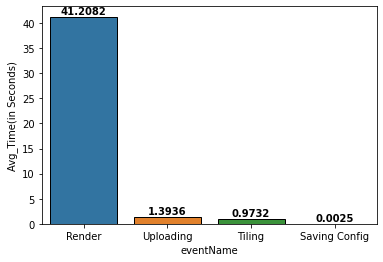

In [11]:
#Function to add label values
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (0.50)
                value = '{:.4f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center",weight='bold') 
                
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

ax = sns.barplot(x='eventName', y='Avg_Time(in Seconds)', data=data1_2,errwidth=0,edgecolor = 'black')
 
#show values on barplot
show_values(ax)


2.	Total runtime taken for the task/position

In [12]:
q12 ="""select q_1_4.*, data2.x, data2.y, data2.level from q_1_4 inner join data2 on q_1_4.taskId = data2.taskId where q_1_4.eventName like '%TotalRender%';"""
data12=pysqldf(q12)

data12["start_dttm"]=data12["start_dttm"].astype('datetime64')
data12["end_dttm"]=data12["end_dttm"].astype('datetime64')
data12['delta_dttm']=data12['end_dttm']-data12['start_dttm']

# arranging in descending order
data12=data12.sort_values(by='delta_dttm', ascending=False)

data12['TotalTime'] = data12['delta_dttm'].dt.total_seconds()
toptask=data12.groupby(['taskId','x','y'], as_index=False)['TotalTime'].sum()
toptask=toptask.sort_values(['TotalTime'], ascending=False)
top10task=toptask.sort_values(['TotalTime'], ascending=False).head(10)
top10task

/usr/local/lib/python3.8/dist-packages/pandas/io/sql.py:717: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  pandas_sql.to_sql(


,taskId,x,y,TotalTime
61474,ef15022d-f816-4434-b41e-709cb996bc08,3,7,93.697
30697,76fb8e93-c3a6-456c-9661-3b7407800027,70,6,89.525
33805,83064f91-5a19-4526-8673-38ab28dd3ab7,14,1,88.224
43629,a95d501e-d5d5-4fb4-9119-98120bf6f4d5,91,105,82.511
9602,25b410b5-f5ef-4a2f-8b21-29175bca35fc,92,106,81.310
53962,d194b27d-d421-47d3-ae41-eed07a00e8d4,92,107,78.751
62904,f4a61a45-2e92-4aa0-9219-4425ce0ec17e,93,107,76.317
38388,94bfb9b3-80c2-44e7-8869-c29a0007bbe0,93,108,74.996
53582,d01f0571-c929-4bb8-9692-5ef053c1da1d,92,104,74.778
20813,51271d84-a39c-4a33-93c0-eda4648ad5bf,95,106,74.718


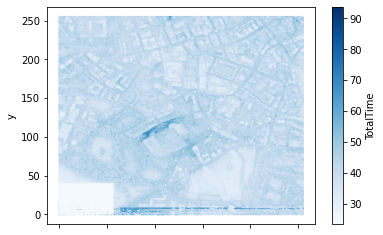

In [13]:
#Ploting the total time in a scatter plot
toptask.plot.scatter(x='x',y='y', c='TotalTime',s=0.5, cmap='Blues')

3.	Higher power draw consumption

In [14]:
avghostpower=cdata3.groupby('hostname', as_index=False)['powerDrawWatt'].mean()
avghostpower=avghostpower.sort_values(['powerDrawWatt'], ascending=False).head(10)
avghostpower

,hostname,powerDrawWatt
687,a77ef58b13ad4c01b769dac8409af3f800000D,106.247462
904,db871cd77a544e13bc791a64a0c8ed5000000U,101.974324
37,04dc4e9647154250beeee51b866b0715000011,101.549633
441,5903af3699134795af7eafc605ae5fc700000H,99.057575
616,8b6a0eebc87b4cb2b0539e81075191b9000016,98.698678
44,04dc4e9647154250beeee51b866b0715000018,98.250353
357,4ad946d4435c42dabb5073531ea4f31500000X,98.150566
537,83ea61ac1ef54f27a3bf7bd0f41ecaa700000D,97.795836
412,4c72fae95b9147189a0559269a6953ff000012,97.771817
57,0745914f4de046078517041d70b22fe7000007,97.535805


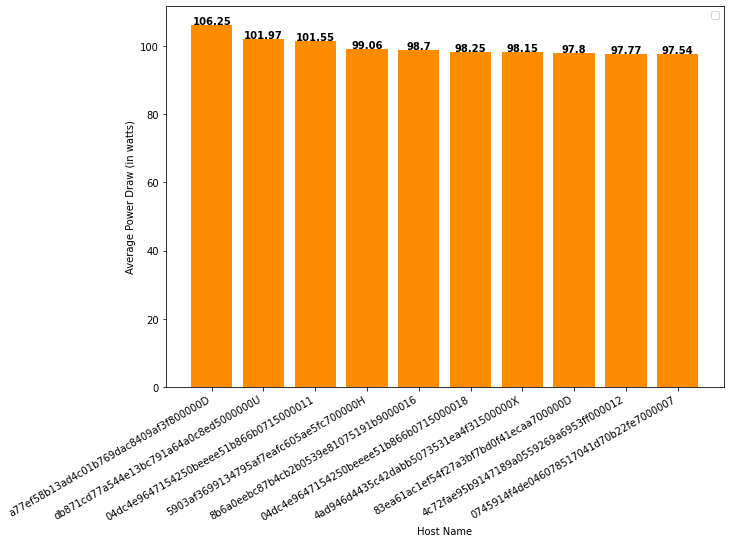

In [15]:
plt.figure(figsize = (10, 7))
plt.bar(avghostpower.hostname, avghostpower.powerDrawWatt, color='darkorange')

addlabels(avghostpower.hostname, avghostpower.powerDrawWatt)
plt.plot()
plt.xticks(rotation=30, ha='right')

plt.xlabel("Host Name")
plt.ylabel("Average Power Draw (in watts)")
plt.title("")
plt.legend()
plt.show()


4.	High temperature GPU cards and the probability of GPU temperature.

In [17]:
avgtemp=cdata3.groupby('gpuSerial', as_index=False)['gpuTempC'].mean()

avgtemp=avgtemp.sort_values(['gpuTempC'], ascending=False).head(10)
avgtemp

,gpuSerial,gpuTempC
556,323617043033,48.926716
447,323617021463,48.153231
940,325217084671,48.128925
88,323217055992,48.008672
130,323217056368,47.523046
278,323617020525,47.379081
474,323617042479,47.255163
680,325017017810,47.247498
517,323617042764,47.109333
491,323617042596,47.088608


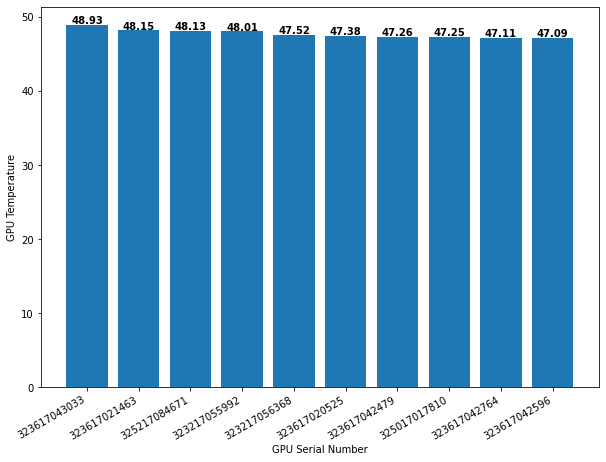

In [18]:
x = avgtemp.gpuSerial
y = avgtemp.gpuTempC
# setting figure size by using figure() function 
plt.figure(figsize = (10, 7))

plt.bar(x, y)
# calling the function to add value labels
addlabels(x, y)

plt.xticks(rotation=30, ha='right')
plt.xlabel("GPU Serial Number")
plt.ylabel("GPU Temperature")
plt.show()

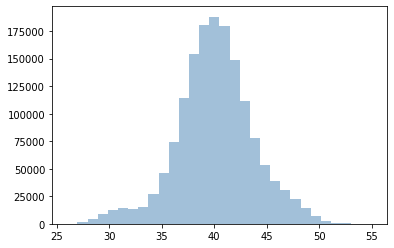

In [19]:
#Histogram for GPU temperature
plt.hist(cdata3['gpuTempC'], bins=30, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none');

5.	Relation between GPU utilisation percentage GPU memory utilisation percentage

In [20]:
rel=cdata3.groupby('gpuSerial', as_index=False)['gpuUtilPerc','gpuMemUtilPerc'].mean()
rel=rel.sort_values(['gpuUtilPerc'], ascending=False)
rel.index

<ipython-input-20-543314f365aa>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rel=cdata3.groupby('gpuSerial', as_index=False)['gpuUtilPerc','gpuMemUtilPerc'].mean()


Int64Index([833, 405, 814, 708, 491, 904, 545, 112,  37, 879,
            ...
            875, 207, 248, 430, 347, 263, 108, 389, 407, 328],
           dtype='int64', length=1024)

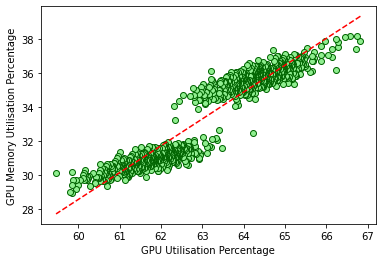

In [21]:
plt.scatter(x=rel.gpuUtilPerc, y=rel.gpuMemUtilPerc, c = 'lightgreen', edgecolor = 'darkgreen');
plt.xlabel("GPU Utilisation Percentage")
plt.ylabel("GPU Memory Utilisation Percentage")
z = np.polyfit(rel.gpuUtilPerc, rel.gpuMemUtilPerc, 1)
p = np.poly1d(z)
plt.plot(rel.gpuUtilPerc,p(rel.gpuUtilPerc),"r--")
plt.show()

6.	Power draw consumption for each event

In [23]:
#Query for joining the three data files
q1_3 ="""select * from data1_2 inner join cdata3 on data1_2.hostname = cdata3.hostname and data1_2.start_dttm <= cdata3.timestamp and data1_2.end_dttm >= cdata3.timestamp;"""
data1_3=pysqldf(q1_3)

#data1_3["start_dttm"]=data1_2["timestamp"].astype('datetime64')


/usr/local/lib/python3.8/dist-packages/pandas/io/sql.py:717: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  pandas_sql.to_sql(


In [24]:
#Get the average of power draw grop by event name
eventpowerDraw=data1_3.groupby('eventName', as_index=False)['powerDrawWatt'].mean()
eventpowerDraw


,eventName,powerDrawWatt
0,Render,97.045833
1,Saving Config,36.087685
2,Tiling,44.756076
3,Uploading,40.495508


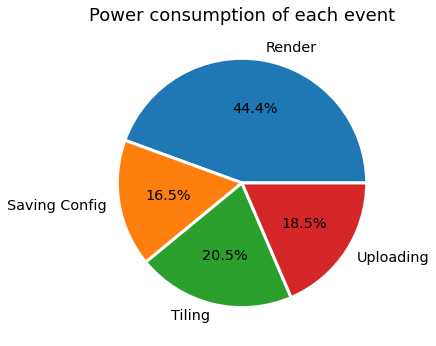

In [25]:
# Plot for pie chart to get the percentage of power consumption
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(eventpowerDraw.powerDrawWatt, labels=eventpowerDraw.eventName, autopct='%.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'w'},
       textprops={'size': 'x-large'})
ax.set_title('Power consumption of each event', fontsize=18)
plt.tight_layout()

7.	Correlation between the GPU specifications

In [110]:
# Get the correlation for the GPU specification
cdata3.corr()

,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc
powerDrawWatt,1.000000,0.537191,0.862673,0.870746
gpuTempC,0.537191,1.000000,0.505906,0.492783
gpuUtilPerc,0.862673,0.505906,1.000000,0.966571
gpuMemUtilPerc,0.870746,0.492783,0.966571,1.000000


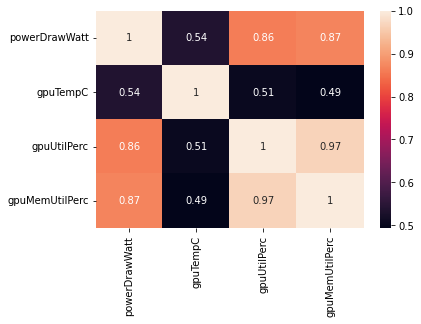

In [94]:
#Plot the heat map for analysing correlation
sns.heatmap(cdata3.corr(), annot=True)